# Movie Investing / Return on Investment

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import t, ttest_ind, kstest, norm

## Data Sets Import

In [49]:
# table containing title, name code and category of the person
crew_movie = pd.read_csv('title.principals.tsv', sep = '\t')

In [50]:
# table containing title name, genre and year
titles = pd.read_csv('title.basics.tsv', sep = '\t')

In [51]:
#table mapping name code and name
names = pd.read_csv('name.basics.tsv', sep = '\t')

In [52]:
# table with film title and US Box Office
bo = pd.read_csv('boxoffice.csv')

In [53]:
## Table with movie title, budget  and international revenue
mm = pd.read_csv('movies_metadata.csv')

## Data Cleaning

In [54]:
#drop not used professions in category and not used columns
drop_list = ['self', 'production_designer', 'archive_footage', 'archive_sound','cinematographer',\
            'producer','editor','writer']
crew_movie = crew_movie[~crew_movie.category.isin(drop_list)]
crew_movie.drop(columns = ['characters', 'job'], inplace = True)

In [55]:
#drop not used columns
titles.drop(columns=['endYear', 'originalTitle'], inplace = True)

#drop titles that do not have a year
titles = titles[titles['startYear'] != '\\N']

#convert column to numeric
titles['startYear'] = titles['startYear'].astype(int)

# remove Adult titles, keep only titles that are movies and were released after 1997 (20 years of data)
titles = titles[(titles.titleType == 'movie') & (titles.isAdult == 0) & (titles.startYear > 1997)]

#drop Adult column
titles.drop(columns=['titleType','isAdult'], inplace = True)

In [56]:
#drop unused columns
names.drop(columns = ['knownForTitles','primaryProfession'], inplace = True)
#remove persons that have already died or ones that do not have birthdate available
names[(names.deathYear == '\\N') & (names.birthYear != '\\N')]

,nconst,primaryName,birthYear,deathYear
2,nm0000003,Brigitte Bardot,1934,\N
13,nm0000014,Olivia de Havilland,1916,\N
46,nm0000047,Sophia Loren,1934,\N
78,nm0000079,Raquel Welch,1940,\N
83,nm0000084,Li Gong,1965,\N
...,...,...,...,...
9970721,nm9992650,Pardeep Singh Sooch,1987,\N
9970829,nm9992812,Daisy,1994,\N
9970939,nm9992946,Christoph Blaschke,1993,\N
9970963,nm9992971,Shamica Anderson,1988,\N


In [57]:
bo = bo[bo.year > 1997] #keep only titles after 1997
bo.drop(columns = ['rank', 'studio'], inplace = True) #drop unused columns

In [58]:
#convert budget to numeric. if value is not "readable", just default to 0.
for i,element in enumerate(mm.budget):
    try:
        int(element)
    except:
        mm.at[i, 'budget'] = 0

In [59]:
mm['budget'] = mm.budget.astype(int)

#remove adult movies and movies with no budget info
mm = mm[(mm.adult == 'False') & (mm.budget > 0)]

#keep only needed columns
mm_columns_to_keep = ['budget','imdb_id', 'original_language', 'original_title', 'revenue']
mm = mm[mm_columns_to_keep]

## Data Merging

In [60]:
#Create dataframe with all per title information

# merge the dataframes
titles_merged_tmp = pd.merge(titles, bo, how='inner', left_on = 'primaryTitle', right_on = 'title')
titles_merged = pd.merge(titles_merged_tmp, mm, how='inner', left_on = 'tconst', right_on = 'imdb_id')

# split the genres in different columns
titles_merged [['genre1', 'genre2', 'genre3']] = titles_merged.genres.str.split(',', expand=True)

#Drop not needed columns after merge
titles_merged.drop(columns = ['primaryTitle', 'imdb_id','original_title'], inplace = True)

# where values are 0 replace with NaN
titles_merged.loc[titles_merged.budget == 0,'budget'] = np.nan
titles_merged.loc[titles_merged.lifetime_gross == 0,'lifetime_gross'] = np.nan
titles_merged.loc[titles_merged.revenue == 0,'revenue'] = np.nan

#create profit column
titles_merged['profit'] = titles_merged.revenue - titles_merged.budget

#create outside US gross column
titles_merged['outus_gross'] = titles_merged.revenue - titles_merged.lifetime_gross

titles_merged

,tconst,startYear,runtimeMinutes,genres,title,lifetime_gross,year,budget,original_language,revenue,genre1,genre2,genre3,profit,outus_gross
0,tt0113026,2000,86,"Musical,Romance",The Fantasticks,49666.0,2000,10000000.0,en,NaN,Musical,Romance,None,NaN,NaN
1,tt0118589,2001,104,"Drama,Music,Romance",Glitter,4274407.0,2001,22000000.0,en,5271666.0,Drama,Music,Romance,-16728334.0,997259.0
2,tt0118636,1998,111,"Crime,Drama,Thriller",Apt Pupil,8863193.0,1998,14000000.0,en,NaN,Crime,Drama,Thriller,NaN,NaN
3,tt0449467,2006,143,Drama,Babel,34302837.0,2006,25000000.0,en,135330182.0,Drama,None,None,110330182.0,101027345.0
4,tt0118665,1999,97,"Comedy,Crime,Family",Baby Geniuses,27250736.0,1999,12000000.0,en,36450736.0,Comedy,Crime,Family,24450736.0,9200000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3565,tt6003368,2017,91,"Comedy,Family",Diary of a Wimpy Kid: The Long Haul,20738724.0,2017,22000000.0,en,40120144.0,Comedy,Family,None,18120144.0,19381420.0
3566,tt6083388,2017,128,"Action,History",God of War,53496.0,2017,25000000.0,zh,NaN,Action,History,None,NaN,NaN
3567,tt6265828,2017,92,"Drama,Fantasy,Romance",A Ghost Story,1596371.0,2017,100000.0,en,15584255.0,Drama,Fantasy,Romance,15484255.0,13987884.0
3568,tt6322922,2017,98,Documentary,An Inconvenient Sequel: Truth to Power,3496795.0,2017,1000000.0,en,NaN,Documentary,None,None,NaN,NaN


In [61]:
#Create df with all title data + people per movie ( 1 line per person+movie)

all_data_tmp = pd.merge(titles_merged, crew_movie, how='inner')
all_data = pd.merge (all_data_tmp, names,how='inner')
all_data = all_data[all_data.deathYear == '\\N']
all_data.drop(columns = ['tconst','startYear','genres','ordering','nconst','deathYear'], inplace = True)
all_data.columns = ['runtime', 'title', 'us_gross', 'year', 'budget','original_language', 'int_gross', 'genre1', 'genre2', 'genre3','profit','outus_gross', 'category', 'name', 'birthyear']

## Functions

In [73]:
def create_genre_df(df):
    # Function that return a Dictionary with pairs genre : titles in genre
    # Get unique values per genre & dataframes per genre
    genres_values = pd.unique(df[['genre1', 'genre2', 'genre3']].values.ravel('K'))
    genres_values = genres_values[genres_values != None]
    return  {genre:df[(df.genre1 == genre)|(df.genre2 == genre)| (df.genre3 == genre)] for genre in genres_values}

def color_maps(c1,c2,c3,c4,c5,c6,int1,int2,int3,element):
    #function to define colormap
    cm1 = np.arange(c1, c4, int1) [0:len(element)][::-1]
    cm2 = np.arange(c2, c5, int2) [0:len(element)] [::-1]
    cm3 = np.arange(c3, c6, int3) [0:len(element)][::-1]
    return tuple([(cm1[i], cm2[i],cm3[i]) for i in range(len(element))])

def plot_genres(df):
    #generate plots for genres
    cma = color_maps(0,0,0,0.9,0.9,0.9,0.0001,0.0001,0.03,df)#colormap for bars
    violin_plot(df,cma,'Gross per Genre','genre')

def cat_plot(money_stats, cat, min_samp):
    #Generate plots for category
    df_cat = money_stats[(money_stats.category == cat) & (money_stats.samples_profit>min_samp)]
    df_cat.sort_values(by = 'profit_mean',inplace = True, ascending = False)
    df_cat = df_cat[0:10]
    cma = color_maps(0,0,0,0.9,0.9,1,0.0001,0.0001,0.08,df_cat)
    violin_plot(df_cat,cma,cat,'name')
    
def violin_plot(df,cma,cat,variable):
    #Create Violin Plot
    pos_list = ['top','right','left','bottom']
    
    fig, axs = plt.subplots(1,2, figsize = (15,6))

    y_pos = np.arange(len(df))
    x_r1 = list((df.us_gross_mean - df.us_gross_max)/1e6)
    x_r2 = list((df.non_us_gross_mean - df.non_us_gross_max)/1e6)

    for pos in pos_list: axs[0].spines[pos].set_visible(False)
    axs[0].axes.get_yaxis().set_visible(False)

    ax_inv = axs[0].twinx()
    ax_inv.axes.get_yaxis().set_visible(False)

    for pos in pos_list: ax_inv.spines[pos].set_visible(False)
    ax_inv.barh(y_pos,df.non_us_gross_mean[::-1]/1e6, xerr=x_r2, alpha=0.4, align = 'center', color=cma)
    ax_inv.set_xlim(max(df.non_us_gross_mean)/1e6*1.5,0)
    ax_inv.set_title ('Non US Total Gross', fontsize = 14, fontweight = 'bold')

    for pos in pos_list: axs[1].spines[pos].set_visible(False)

    axs[1].set_xlim(0,max(df.non_us_gross_mean)/1e6*1.5)
    axs[1].barh(y_pos,df.us_gross_mean[::-1]/1e6, xerr=x_r1, alpha=0.4,color=cma)
    axs[1].set_yticks(y_pos)
    axs[1].set_yticklabels(df[variable][::-1])
    axs[1].set_title ('US Total Gross', fontsize = 14, fontweight = 'bold')

    plt.suptitle(cat,fontsize = 14, fontweight = 'bold')
    plt.text(0, -1.8, '$USD million')
    
    plt.gca()
    plt.savefig(str(i) + '.png')
    plt.show()
    
    
def create_df_genre(df, max_budget = None):
    #Create Dataframe with genre, nb of samples, max, min, mean and conf. interval for US Gross,
    # Non US Gross and profit

    genres_df= create_genre_df(df)

    column_names = ['genre', 'samples_us', 'samples_non_us', 'samples_profit', \
                'us_gross_mean', 'non_us_gross_mean', 'profit_mean', \
                'us_gross_min', 'us_gross_max', 'non_us_gross_min', 'non_us_gross_max', \
                'profit_min', 'profit_max']

    money_genre = pd.DataFrame(columns = column_names)

    #iterate dic per genre
    for genre, tmp in genres_df.items():
  
      if max_budget != None: tmp = tmp[tmp.budget < max_budget * 1000000]
    
      # count samples (NaN are not counted)
      samples_pr = tmp.profit.count()
      samples_us = tmp.lifetime_gross.count()
      samples_nonus = tmp.outus_gross.count()
  
      # calculate means per genre
      mean_pr = tmp.profit.mean()
      mean_us_gross = tmp.lifetime_gross.mean()
      mean_out_gross = tmp.outus_gross.mean()

      # calculate confidence intervals per genre 
      pr_int = t.interval(0.95,tmp.profit.count()-1, tmp.profit.mean(), tmp.profit.std()/np.sqrt(tmp.profit.count()-1))
      us_gr_int = t.interval(0.95,tmp.lifetime_gross.count()-1, tmp.lifetime_gross.mean(), tmp.lifetime_gross.std()/np.sqrt(tmp.lifetime_gross.count()-1))                       
      outus_gr_int = t.interval(0.95,tmp.outus_gross.count()-1, tmp.outus_gross.mean(), tmp.outus_gross.std()/np.sqrt(tmp.outus_gross.count()-1))

      #add line to dataframe with previous info
      money_genre = money_genre.append(pd.DataFrame([[genre,samples_us, \
                samples_nonus, samples_pr, mean_us_gross, mean_out_gross,mean_pr, \
                us_gr_int[0], us_gr_int[1], outus_gr_int[0], outus_gr_int[1],\
                pr_int[0], pr_int[1]]], columns = column_names))

    #add columns with confidence intervals (max-min)
    money_genre['us_gross_int'] = money_genre.us_gross_max - money_genre.us_gross_min
    money_genre['profit_int'] = money_genre.profit_max - money_genre.profit_min
    money_genre['non_us_gross_int'] = money_genre.non_us_gross_max - money_genre.non_us_gross_min

    #sort dataframe per Non US Gross mean
    money_genre.sort_values(by = 'non_us_gross_mean',inplace = True, ascending = False)
    return money_genre


def create_df_category(df, max_budget=None):

    #Create statistics DF for categories
    
    pro_cat = df.category.unique()
    pro_cat_values = {cat : df.loc[df['category'] == cat].name.unique() for cat in pro_cat}
    
    column_names = ['category', 'name', 'samples_us', 'samples_non_us', 'samples_profit', 'us_gross_mean', 'non_us_gross_mean', 'profit_mean', \
               'us_gross_min', 'us_gross_max', 'non_us_gross_min', 'non_us_gross_max', \
               'profit_min', 'profit_max']

    money_stats = pd.DataFrame(columns = column_names)

    for cat, members in pro_cat_values.items():
     for member in members:
      
      if max_budget!=None:  
          tmp = df.loc[(df.name == member) & (df.category == cat) & (df.budget < max_budget * 1000000)][['profit', 'us_gross', 'outus_gross']]
      else:
          tmp = df.loc[(df.name == member) & (df.category == cat)][['profit', 'us_gross', 'outus_gross']]
              
      samples_pr = tmp.profit.count()
      samples_us = tmp.us_gross.count()
      samples_nonus = tmp.outus_gross.count()
    
      mean_pr = tmp.profit.mean()
      mean_us_gross = tmp.us_gross.mean()
      mean_out_gross = tmp.outus_gross.mean()
      pr_int = t.interval(0.95,tmp.profit.count()-1, tmp.profit.mean(), tmp.profit.std()/np.sqrt(tmp.profit.count()-1))
      us_gr_int = t.interval(0.95,tmp.us_gross.count()-1, tmp.us_gross.mean(), tmp.us_gross.std()/np.sqrt(tmp.us_gross.count()-1))                       
      outus_gr_int = t.interval(0.95,tmp.outus_gross.count()-1, tmp.outus_gross.mean(), tmp.outus_gross.std()/np.sqrt(tmp.outus_gross.count()-1))

      money_stats = money_stats.append(pd.DataFrame([[cat, member, samples_us, \
                samples_nonus, samples_pr, mean_us_gross, mean_out_gross,mean_pr, \
                us_gr_int[0], us_gr_int[1], outus_gr_int[0], outus_gr_int[1],\
                pr_int[0], pr_int[1]]], columns = column_names))

    return money_stats

## Calculate and Plot for all the data

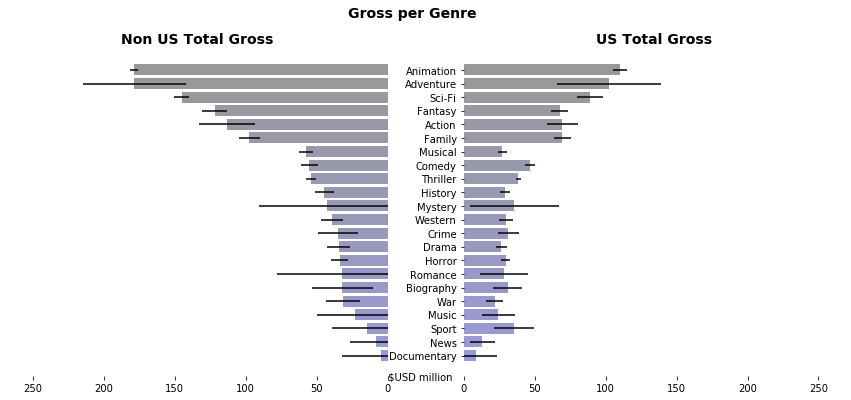

/Users/joaoeira/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: RuntimeWarning: invalid value encountered in sqrt
/Users/joaoeira/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in sqrt
/Users/joaoeira/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


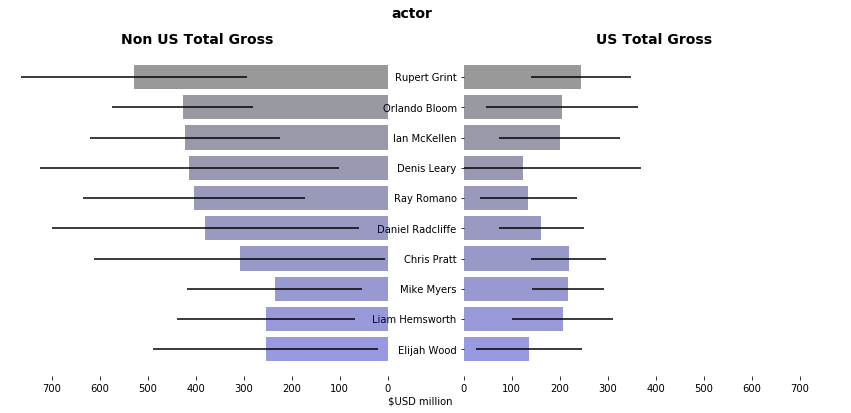

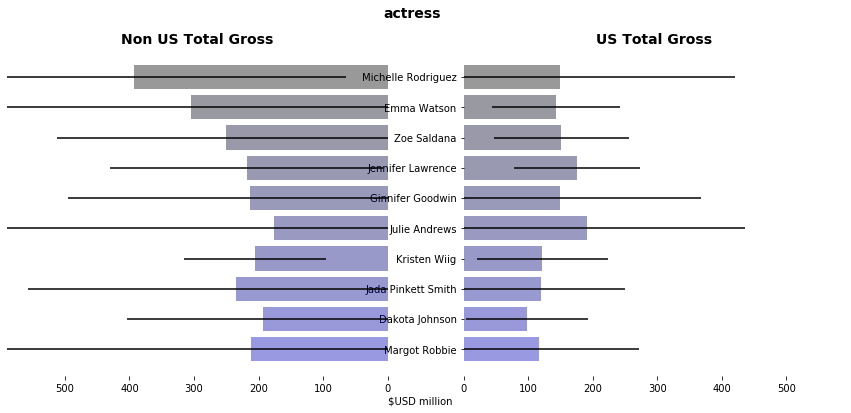

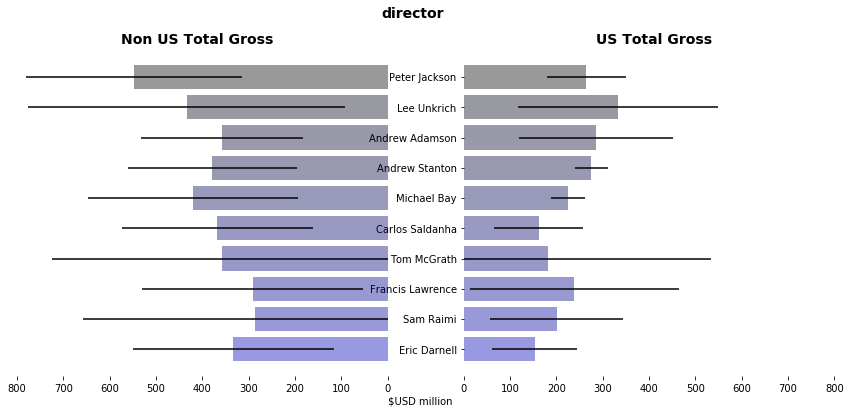

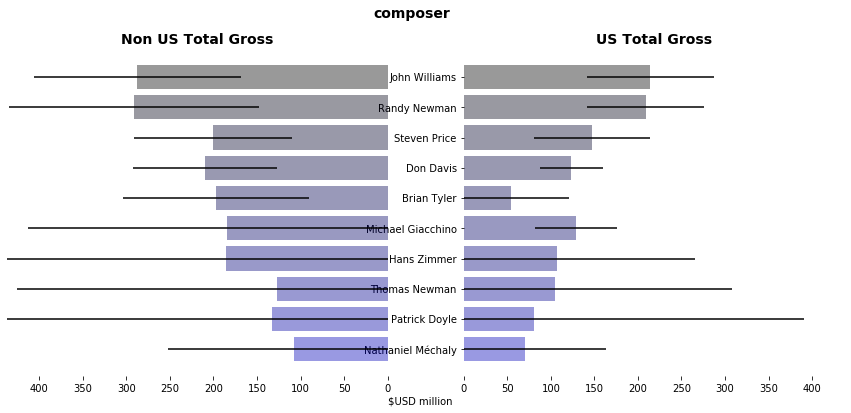

In [74]:
money_genre = create_df_genre(titles_merged)
plot_genres(money_genre)

money_stats = create_df_category(all_data)
for i,cat in enumerate(['actor', 'actress',  'director', 'composer']): cat_plot(money_stats, cat,3) 

## Calculate and Plot with a Budget Limitation

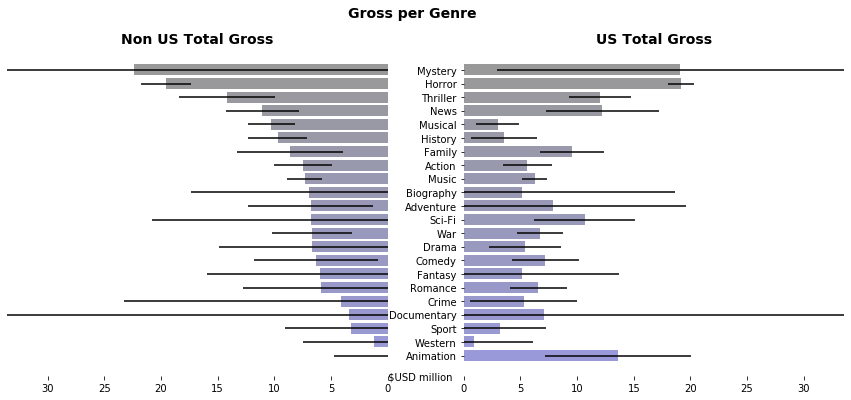

/Users/joaoeira/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: RuntimeWarning: invalid value encountered in sqrt
/Users/joaoeira/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in sqrt
/Users/joaoeira/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in sqrt
/Users/joaoeira/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


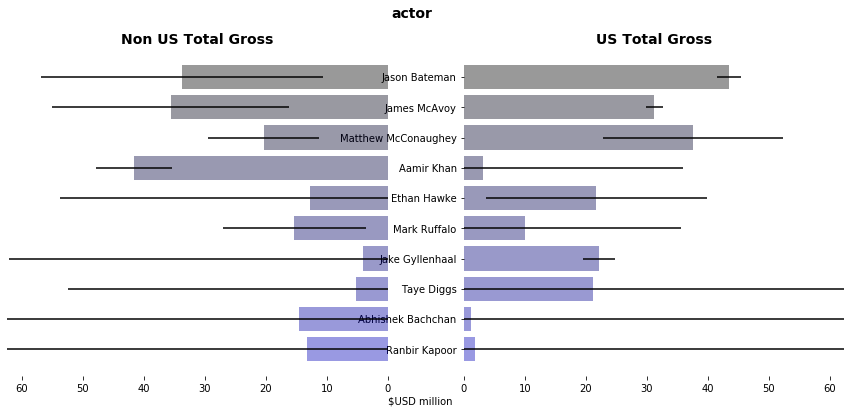

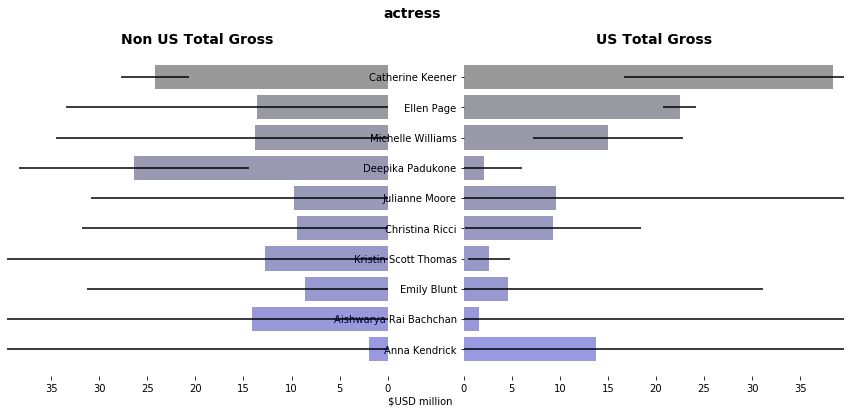

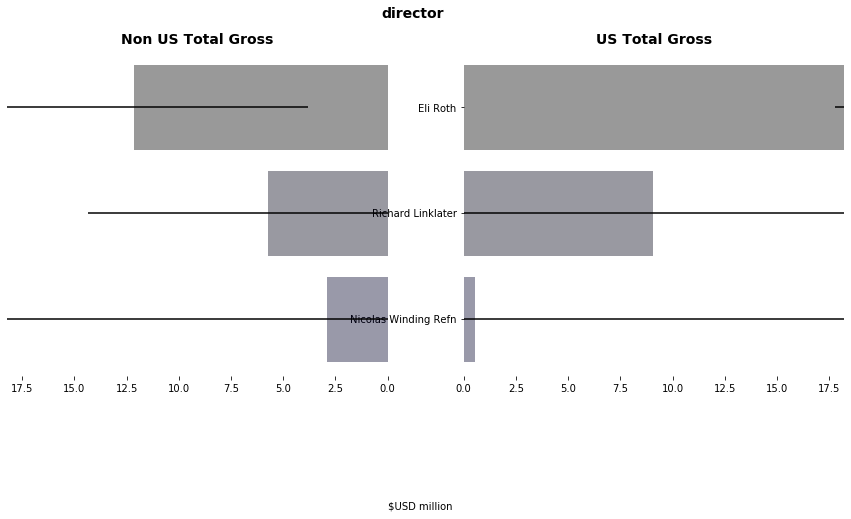

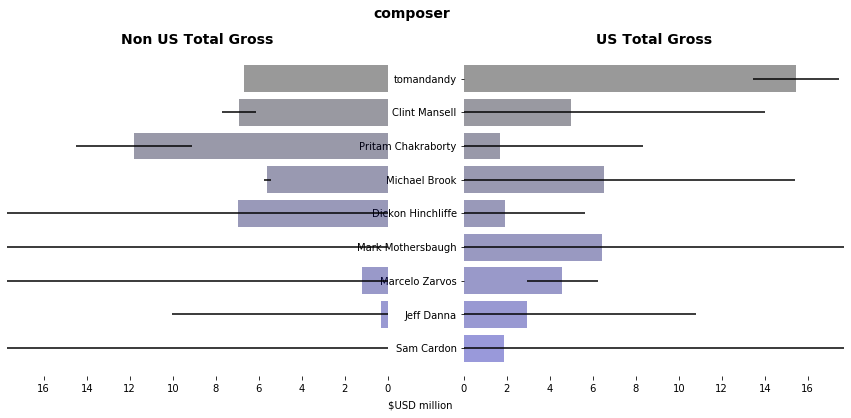

In [75]:
money_genre = create_df_genre(titles_merged, max_budget = 10)
plot_genres(money_genre)
money_stats = create_df_category(all_data, max_budget = 10)
for i,cat in enumerate(['actor', 'actress',  'director', 'composer']): cat_plot(money_stats,cat,3)  

## Analysis of Influence of Blockbuster Franchises

##### Top Actors seem to come from "big" movie franchises, which can be a hint that top results are being driven by the franchise and not by the stars. 

##### Will create a sample without these big franchises and do t-test + ANOVA to compare if samples come from different distributions or not 

In [76]:
# Movies to be removed corresponding to big franchises

patterns = '|'.join(['hunger games', 'wolverine', 'transformers', 'wonder woman', 'x-men',\
           'ant-man', 'avatar', 'batman', 'captain america', 'doctor strange', 'fast',\
           'furious', 'fantastic four', 'G.I.', 'guardians of the galaxy', 'harry potter',\
           'hobbit', 'dark knight', 'narnia', 'superman', 'spider-man', 'hulk', 'indiana jones',\
           'ironman', 'jurassic', 'man of steel', 'men in black', 'mission impossible', 'pirates of',\
           'star wars', 'star trek', 'lord of the rings', 'ice age', 'cars', 'despicable', 'toy story',\
           'madagascar','avengers', 'iron man', 'thor', 'dark world', 'mission: impossible',\
           'skyfall', 'spectre', 'quantum of solace', 'casino royale','planet of the apes',
           'twilight', 'matrix'])

#Dataframes with removed franchises & only Franchises
titles_merged['title'] = titles_merged.title.str.lower()
titles_nf = titles_merged[~titles_merged['title'].str.contains(patterns)]
titles_f = titles_merged[titles_merged['title'].str.contains(patterns)]

all_data['title'] = all_data.title.str.lower()
all_data_nf = all_data[~all_data['title'].str.contains(patterns)]
all_data_nf = all_data_nf[(all_data_nf['genre1']!= 'Animation') & (all_data_nf['genre2']!= 'Animation') & (all_data_nf['genre3']!= 'Animation')]

#Statiscal T test on the difference of the populations
stats, value = ttest_ind(titles_f.profit, titles_nf.profit, nan_policy='omit')
print(stats,value)

# Null Hip. Rejected --> There is a significant difference between the means of the samples

41.126552046746774 4.610413093606278e-293


No handles with labels found to put in legend.


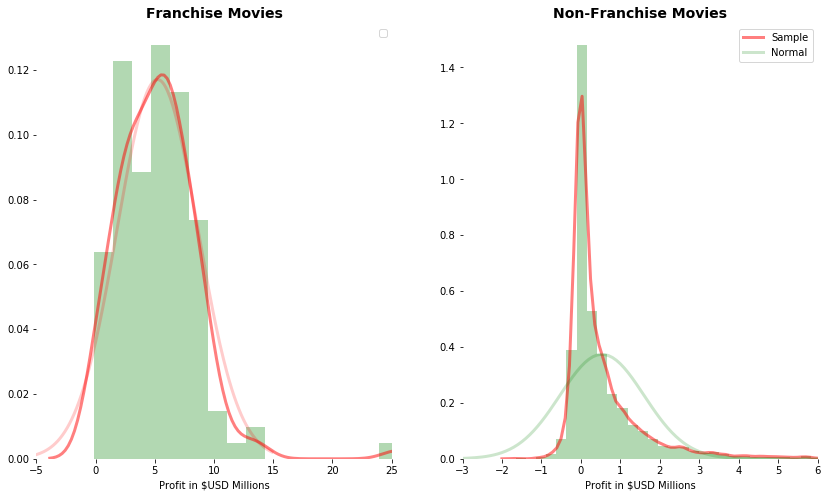

0.9763779527559056 5.1565209156419204e-207
0.6707659873506676 0.0


In [77]:
fig, axs = plt.subplots(1,2, figsize = (14,8))

normal1 = norm(titles_f.profit.mean()/1e8, titles_f.profit.std()/1e8)
test1 = list(titles_f.profit.dropna())

normal2 = norm(titles_nf.profit.mean()/1e8, titles_nf.profit.std()/1e8)
test2 = list(titles_nf.profit.dropna())

sns.distplot(titles_f.profit/1e8, ax = axs[0],kde_kws={"color":'red' , "lw": 3, "alpha": 0.5},\
             hist_kws={"linewidth": 3,"alpha": 0.3, "color": 'green'})
sns.distplot(titles_nf.profit/1e8, ax = axs[1],kde_kws={"color":'red' , "lw": 3, "alpha": 0.5, "label":'Sample'},\
             hist_kws={"linewidth": 3,"alpha": 0.3, "color": 'green'})

x = np.arange(-5,15,0.1)
axs[0].plot(x,normal1.pdf(x), lw = 3, c = 'red', alpha =0.2)
axs[0].set_xlim(-5,25)
axs[0].set_title('Franchise Movies', fontsize = 14, fontweight = 'bold')
axs[0].set_xlabel('Profit in $USD Millions', )
axs[1].plot(x,normal2.pdf(x), lw = 3, c = 'green', alpha =0.2, label = 'Normal')
axs[1].set_xlim(-3,6)
axs[1].set_title('Non-Franchise Movies',fontsize = 14, fontweight = 'bold')
axs[1].set_xlabel('Profit in $USD Millions')

axs[0].legend()
axs[1].legend()

pos_list = ['top','right','left','bottom']
for pos in pos_list: 
    axs[0].spines[pos].set_visible(False)
    axs[1].spines[pos].set_visible(False)

plt.gca()
filename= 'Dists.png'
plt.savefig(filename)
plt.show()

stat1, pvalue1 = kstest(test1, normal1.cdf)
stat2, pvalue2 = kstest(test2, normal2.cdf)

print(stat1, pvalue1)
print(stat2, pvalue2)
# Can reject Null Hip, Samples is not Normal in both cases --> Cannot do Anova

## Calculate and Plot Excluding Franchises

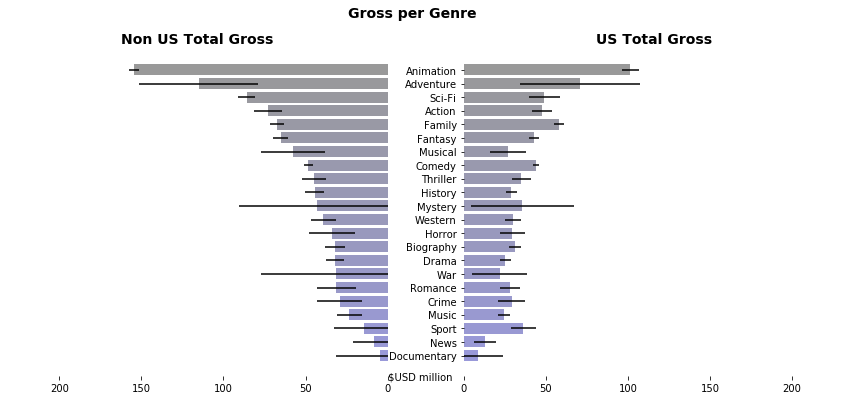

/Users/joaoeira/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: RuntimeWarning: invalid value encountered in sqrt
/Users/joaoeira/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in sqrt
/Users/joaoeira/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


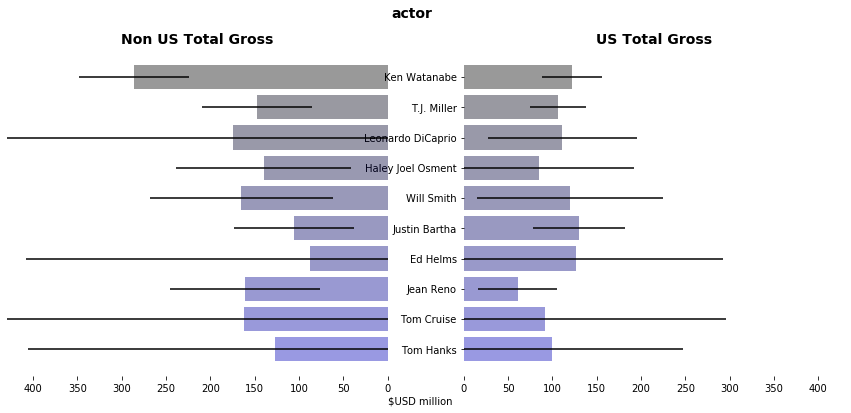

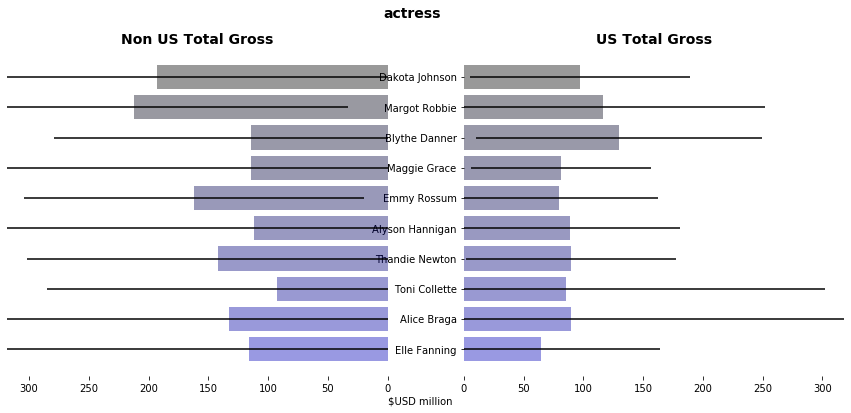

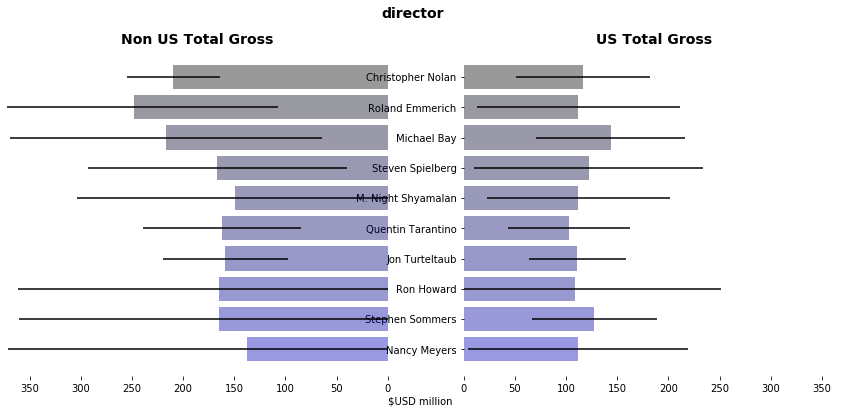

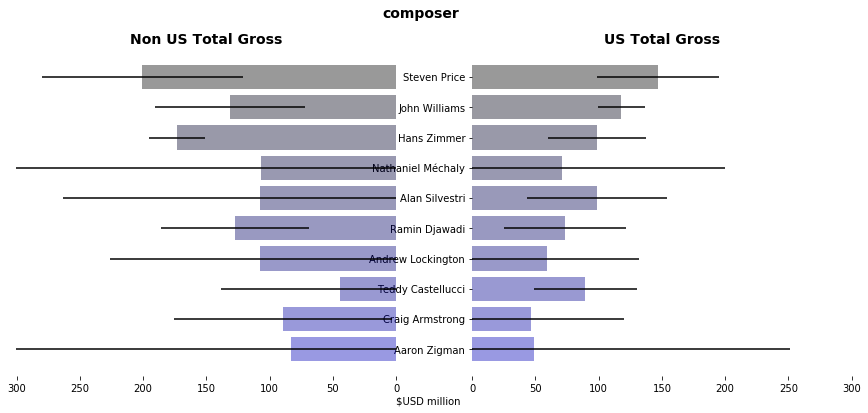

In [78]:
money_genre = create_df_genre(titles_nf)
plot_genres(money_genre)

money_stats = create_df_category(all_data_nf)
for i,cat in enumerate(['actor', 'actress',  'director', 'composer']): cat_plot(money_stats,cat,3) 